In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
import re
import pandas as pd
import numpy as np
from scipy.special import gamma as GammaFunction
import pymc as pm
import arviz as az
import bambi as bmb
import pytensor.tensor as at
import matplotlib.pyplot as plt
import seaborn as sns
import dirichlet
import attila_utils
import mwm
#plt.rcParams['figure.dpi'] = 200

In [2]:
group2condition1 = {
    'A': 'WT',
    'B': '5xFAD',
    'C': '5xFAD + Amiloride',
}

group2condition2 = {
    'A': '5xFAD + Amiloride',
    'B': '5xFAD + HCQ',
    'C': '5xFAD + HCQ nano',
    'D': '5xFAD',
    'E': '5xFAD + R-HCQ',
    'F': '5xFAD + S-HCQ',
    'G': '5xFAD + TUDCA',
    'H': 'WT',
    'I': 'WT + TUDCA',
    'J': 'WT + DMSO',
}

## Training trials

In [3]:
def read_data_train(fpath, group2condition):
    data_train = pd.read_excel(fpath, sheet_name='rawdata MWM day 1-4', header=[0,1], index_col=None)
    data_train = pd.DataFrame(data_train.iloc[:, 4:].to_numpy(), columns=data_train.iloc[:, 4:].columns, index=pd.MultiIndex.from_frame(data_train.iloc[:, :4].xs('Covariates', axis=1, level=0)))
    data_train = data_train.stack(level=1)
    data_train = data_train.rename_axis(data_train.index.names[:-1] + ['Day'], axis=0)
    data_train = pd.concat([data_train, data_train.index.to_frame()], axis=1)
    data_train['Day'] = data_train.Day.str.replace('Day ', '').astype('float64')
    #data_train['Day'] = data_train.Day.str.replace('Day ', '').astype(pd.Int64Dtype())
    data_train['Condition'] = data_train.Group.apply(lambda x: group2condition[x])
    data_train['Status'] = np.where(data_train['Latency (s)'] < 60, 'none', 'right') # censoring status
    data_train = data_train.rename({'Latency (s)': 'Latency', 'Velocity (m/s)': 'Velocity', 'Thigmotaxis %': 'Thigmotaxis', 'Floating %': 'Floating', 'Distance (m)': 'Distance'}, axis=1)
    data_train = data_train.rename_axis(['cohort', 'group', 'sex', 'irn', 'day'])
    #data_train = pd.DataFrame(data_train.to_numpy(), index=list(range(data_train.shape[0])), columns=data_train.columns)
    return(data_train)

fpath1 = '../../resources/QPS/5xFAD-mouse/CO26990-behavioral-data-cleaned.xlsx'
data_train1 = read_data_train(fpath1, group2condition1)
data_train1.to_csv('../../results/2023-10-13-5xfad-maze/data_train-CO26990.csv')

fpath2 = '../../resources/QPS/5xFAD-mouse/CO28152-behavioral-data-cleaned.xlsx'
data_train2 = read_data_train(fpath2, group2condition2)
data_train2.to_csv('../../results/2023-10-13-5xfad-maze/data_train-CO28152.csv')
data_train2

Distance (cm)   Floating  Latency  \
cohort group sex irn     day                                        
I      A     f   14627 A Day 1     777.874500   1.331558    60.08   
                         Day 2     678.319250   3.404644    54.28   
                         Day 3     956.991000   1.231691    60.04   
                         Day 4     849.667925   6.595437    48.20   
                 14687 A Day 1     804.980500   1.198402    60.08   
...                                       ...        ...      ...   
VI     J     m   16226   Day 4     681.385500   8.724943    45.64   
                 16234   Day 1     821.930000  18.075912    60.08   
                         Day 2     583.892750  12.500042    45.06   
                         Day 3     637.209750   4.761448    39.08   
                         Day 4     196.447375  10.478817    12.30   

                                Thigmotaxis  Velocity (cm/s) Cohort Group Sex  \
cohort group sex irn     day                                                    
I      A     f   14627 A Day 1    56.790925        12.964550      I     A   f   
                         Day 2    69.234950        12.427325      I     A   f   
                         Day 3    54.427450        15.960700      I     A   f   
                         Day 4    35.809225        15.501930      I     A   f   
                 14687 A Day 1    46.970700        13.416325      I     A   f   
...                                     ...              ...    ...   ...  ..   
VI     J     m   16226   Day 4    38.211750        14.890225     VI     J   m   
                 16234   Day 1    50.599200        13.698863     VI     J   m   
                         Day 2    30.437534        13.445612     VI     J   m   
                         Day 3    31.934102        15.679775     VI     J   m   
                         Day 4    12.971915        15.199125     VI     J   m   

                                    IRN  Day          Condition Status  
cohort group sex irn     day                                            
I      A     f   14627 A Day 1  14627 A  1.0  5xFAD + Amiloride  right  
                         Day 2  14627 A  2.0  5xFAD + Amiloride   none  
                         Day 3  14627 A  3.0  5xFAD + Amiloride  right  
                         Day 4  14627 A  4.0  5xFAD + Amiloride   none  
                 14687 A Day 1  14687 A  1.0  5xFAD + Amiloride  right  
...                                 ...  ...                ...    ...  
VI     J     m   16226   Day 4    16226  4.0          WT + DMSO   none  
                 16234   Day 1    16234  1.0          WT + DMSO  right  
                         Day 2    16234  2.0          WT + DMSO   none  
                         Day 3    16234  3.0          WT + DMSO   none  
                         Day 4    16234  4.0          WT + DMSO   none  

[580 rows x 12 columns]

['named-figure/data-train-corr-plot-matrix.png',
 'named-figure/data-train-corr-plot-matrix.pdf']

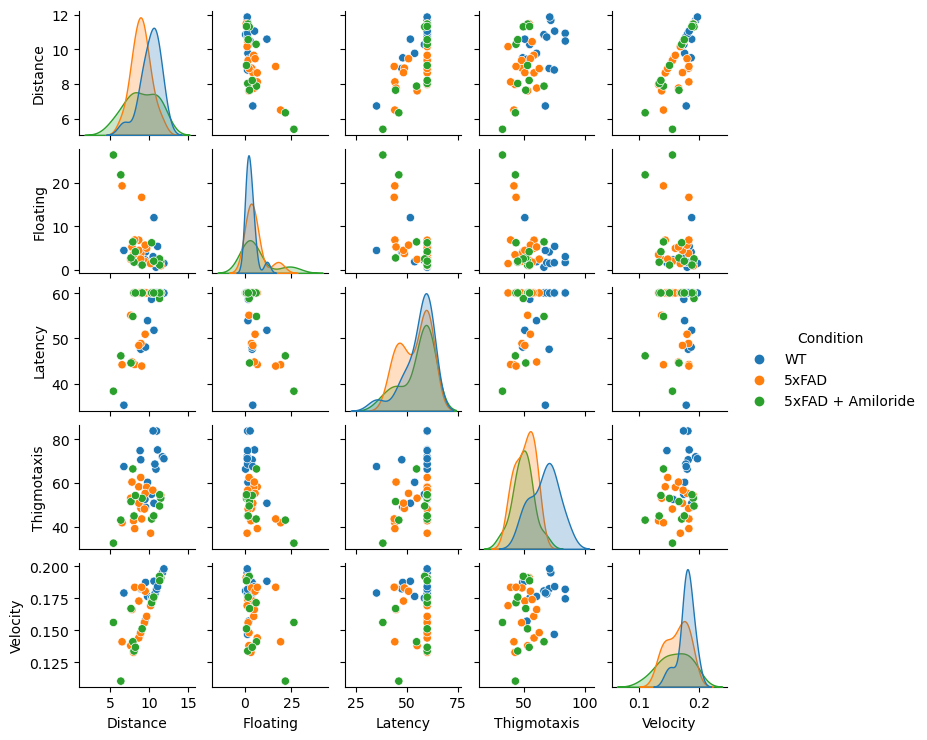

In [4]:
g = sns.pairplot(data_train1.xs('Day 1', level='day', axis=0).drop('Day', axis=1), hue='Condition', height=1.5)
attila_utils.savefig(g, 'data-train-corr-plot-matrix')

In [5]:
experiments = {
    'Amiloride 10': (data_train1, ['5xFAD', '5xFAD + Amiloride', 'WT']),
    'Amiloride 12': (data_train2, ['5xFAD', '5xFAD + Amiloride', 'WT']),
    'HCQ': (data_train2, ['5xFAD', '5xFAD + HCQ', 'WT']),
    'HCQ nano': (data_train2, ['5xFAD', '5xFAD + HCQ nano', 'WT']),
    'R-HCQ': (data_train2, ['5xFAD', '5xFAD + R-HCQ', 'WT + DMSO']),
    'S-HCQ': (data_train2, ['5xFAD', '5xFAD + S-HCQ', 'WT + DMSO']),
    'TUDCA': (data_train2, ['5xFAD', '5xFAD + TUDCA', 'WT']),
    'TUDCA WT': (data_train2, ['WT', 'WT + TUDCA', '5xFAD']),
}


def data_plotter(yname='Latency', data_train=data_train1, lvl=['5xFAD', '5xFAD + Amiloride', 'WT']):
    fig, ax = plt.subplots(1, len(lvl), sharey=True, figsize=(3 * 4.8, 4.8))
    for condition, axi in zip(lvl, ax):
        axi.set_title(condition)
        axi.set_ylabel(yname)
        axi.set_xlabel('Day')
        axi.set_xticks(range(5))
        axi.set_xticklabels(range(5))
        axi.grid(axis='y')
        df1 = data_train.loc[data_train.Condition == condition]
        #df1 = data_train.xs(group, level=1)
        for sex, color in zip(df1.Sex.unique(), ['red', 'blue']):
            df2 = df1.xs(sex, level=2)
            for irn in df2.IRN.unique():
                df3 = df2.xs(irn, level=2)
                for cohort in df3.Cohort.unique():
                    s = sex + cohort
                    y = df3[yname]
                    x = df3.Day
                    axi.plot(x, y, color=color, label=irn, marker='$' + cohort + '$', linewidth=1)
                pass
            pass
        #axi.legend()
    return((fig, ax))

#fig, ax = data_plotter(yname='Latency', lvl=['5xFAD', 'WT', '5xFAD + Amiloride'])

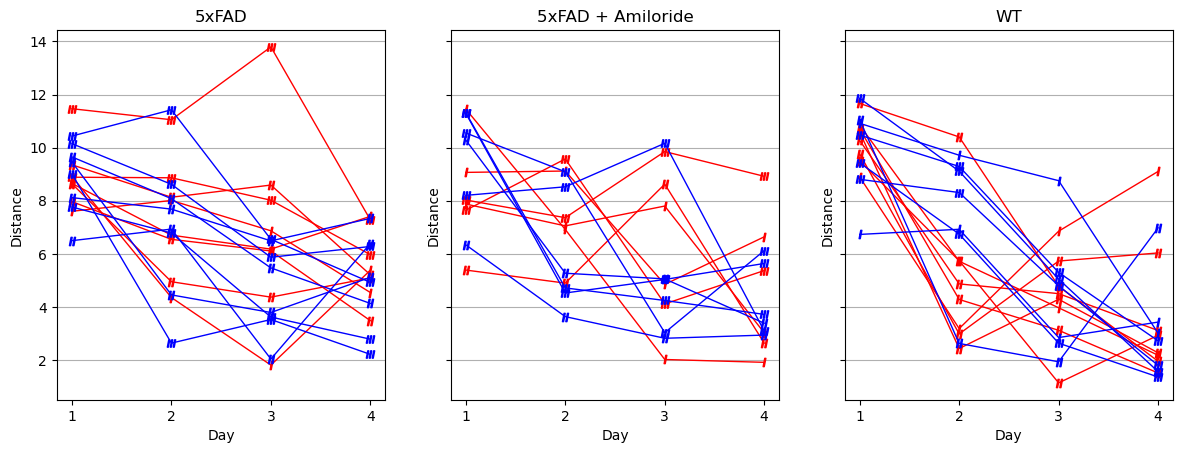

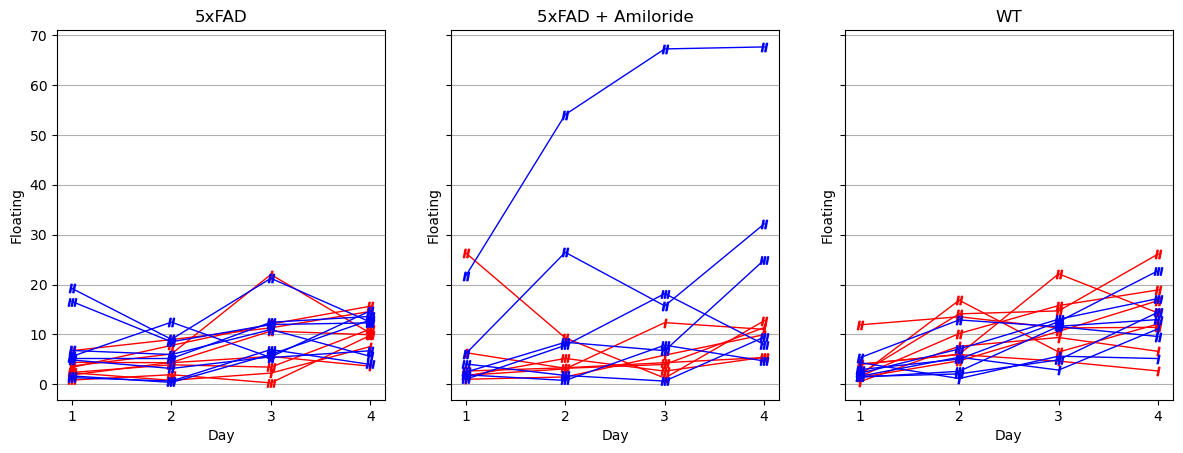

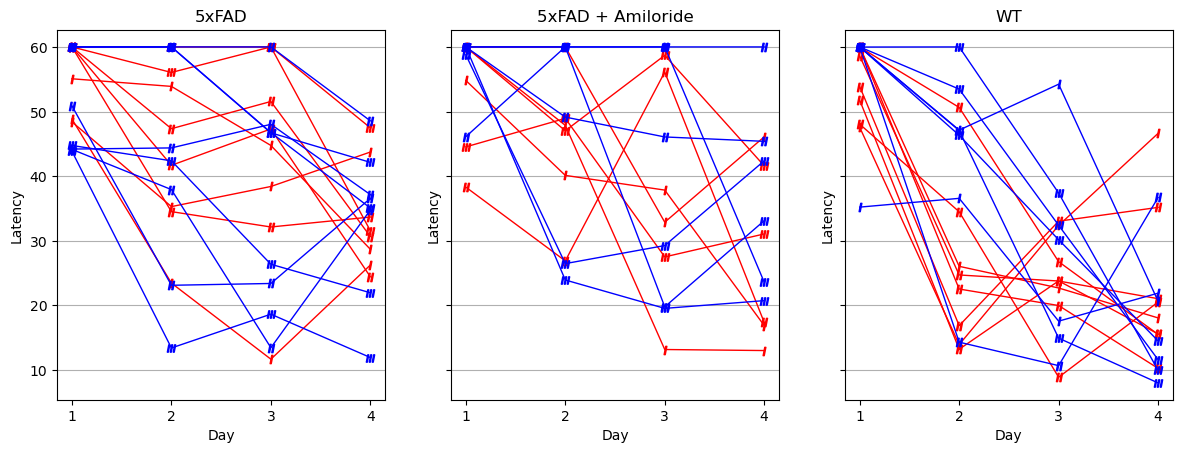

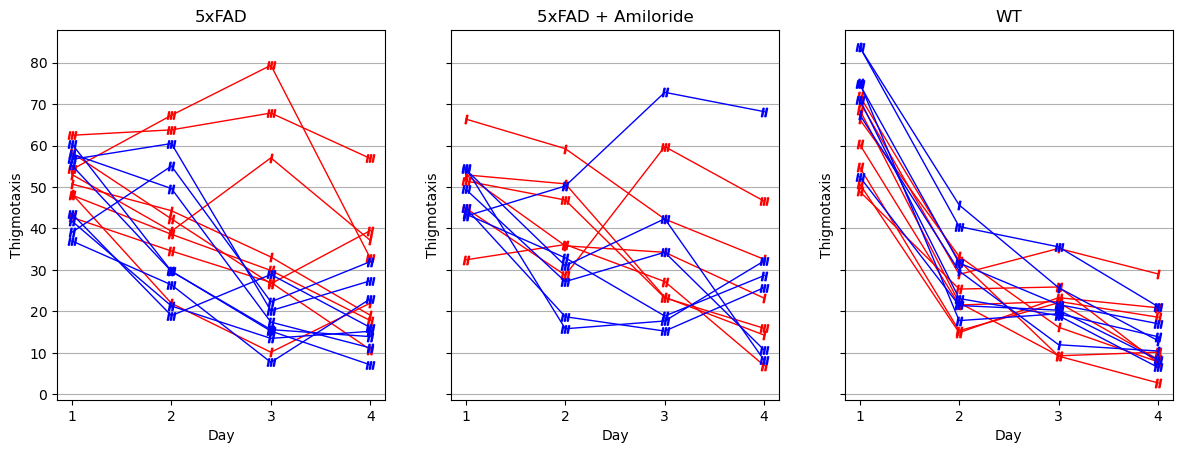

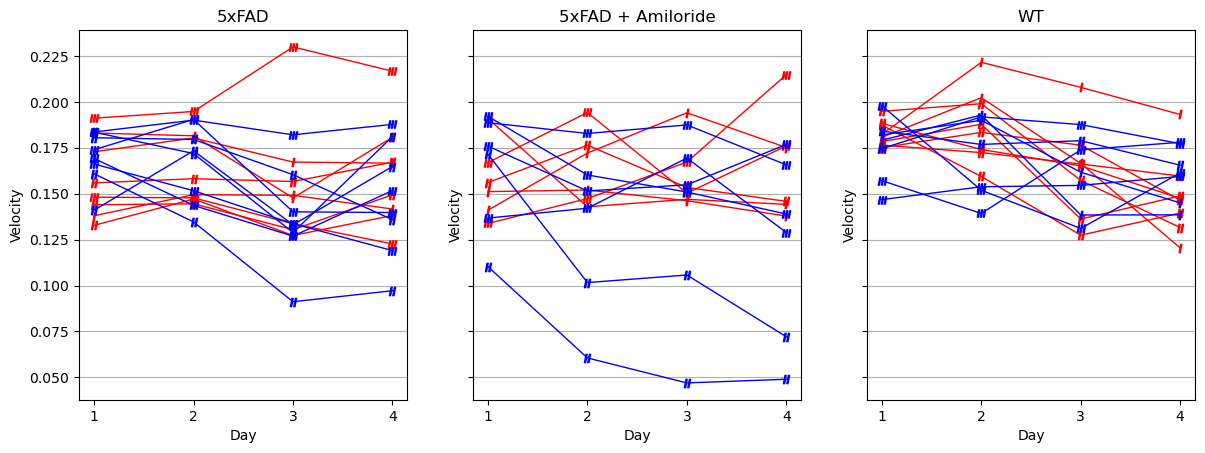

In [6]:
for yname in data_train1.loc[:, :'Velocity'].columns:
    fig, ax = data_plotter(yname=yname, data_train=data_train1)
    attila_utils.savefig(fig, 'training-' + re.sub('[ ()%/]+', '-', yname).strip('-') + '-CO26990')

In [7]:
def latency_plotter(exper, data_train, lvl, experiments=experiments):
    fig, ax = data_plotter(yname='Latency', data_train=data_train, lvl=lvl)
    fig.suptitle(exper, fontsize=16, va='bottom')
    return((fig, ax))

#exper = 'Amiloride 12'
#fig, ax = latency_plotter(exper, *experiments[exper], experiments=experiments)

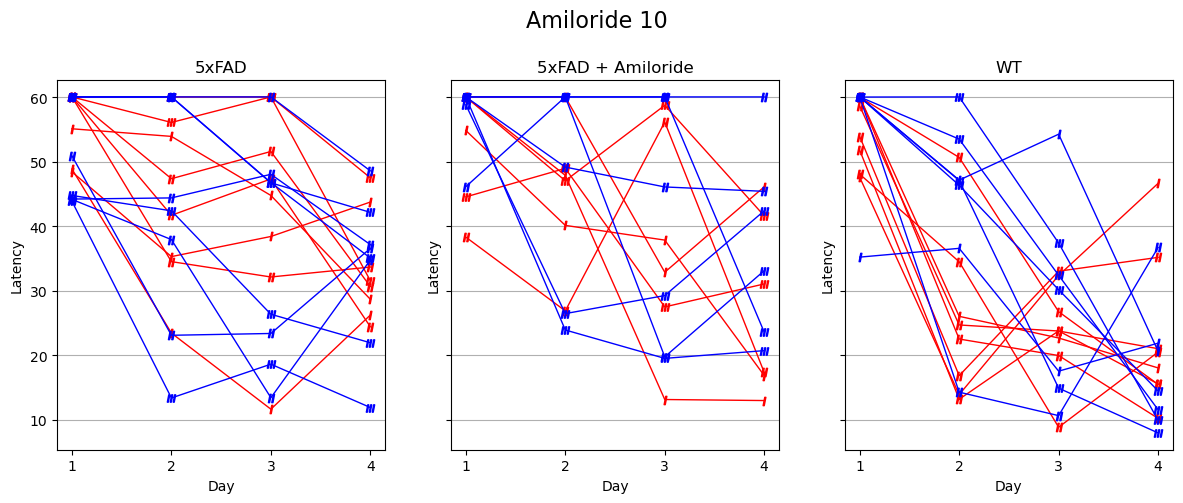

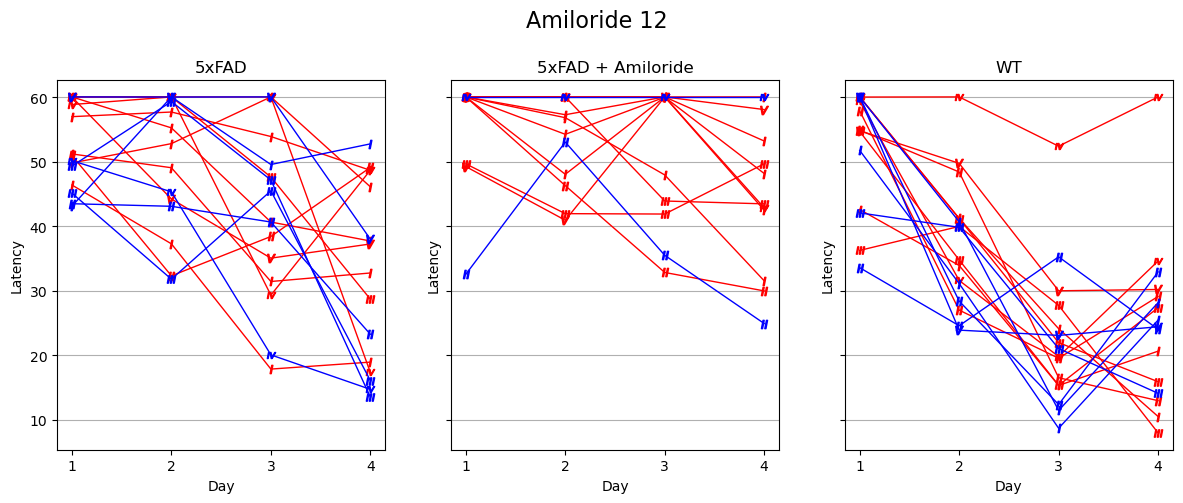

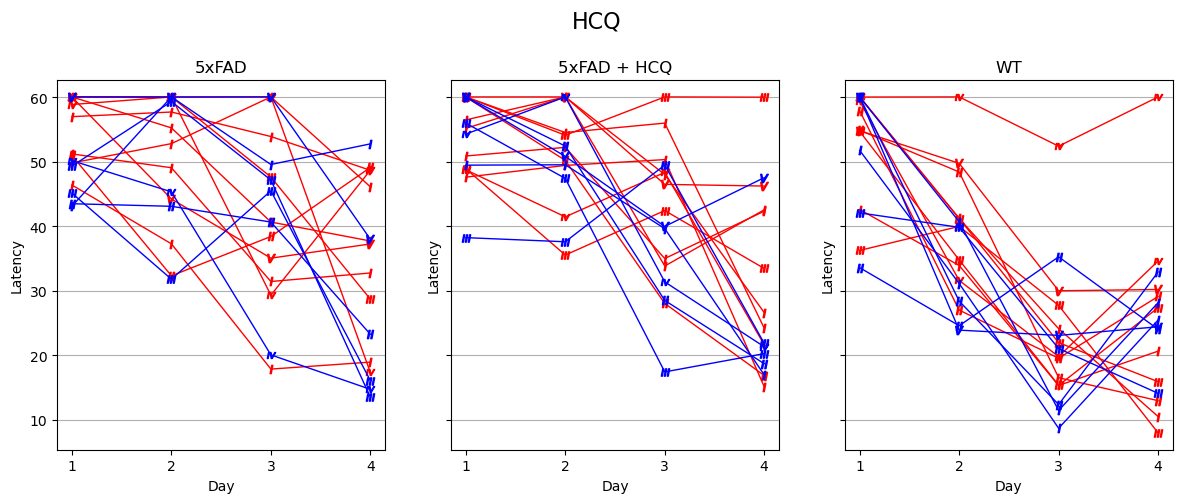

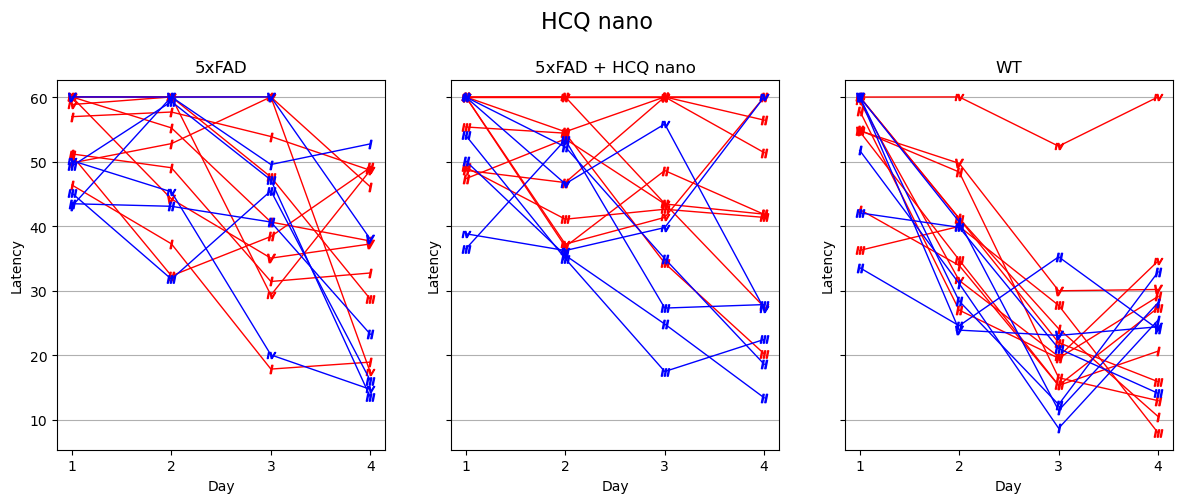

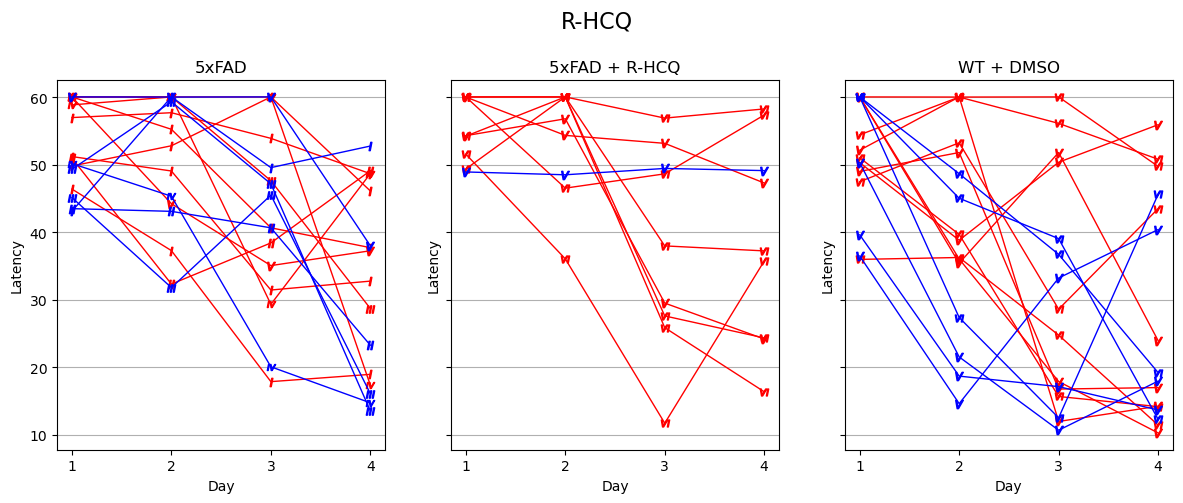

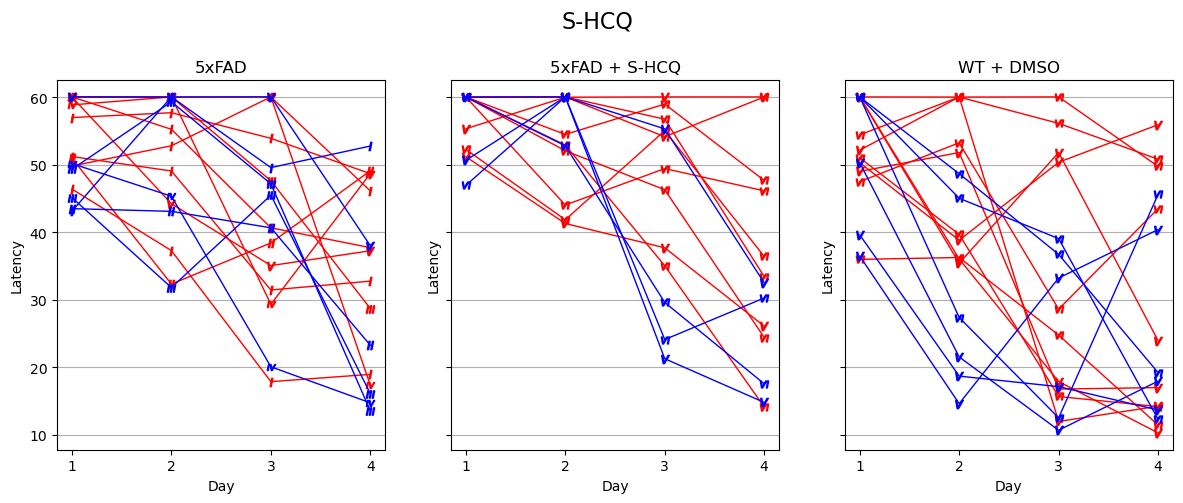

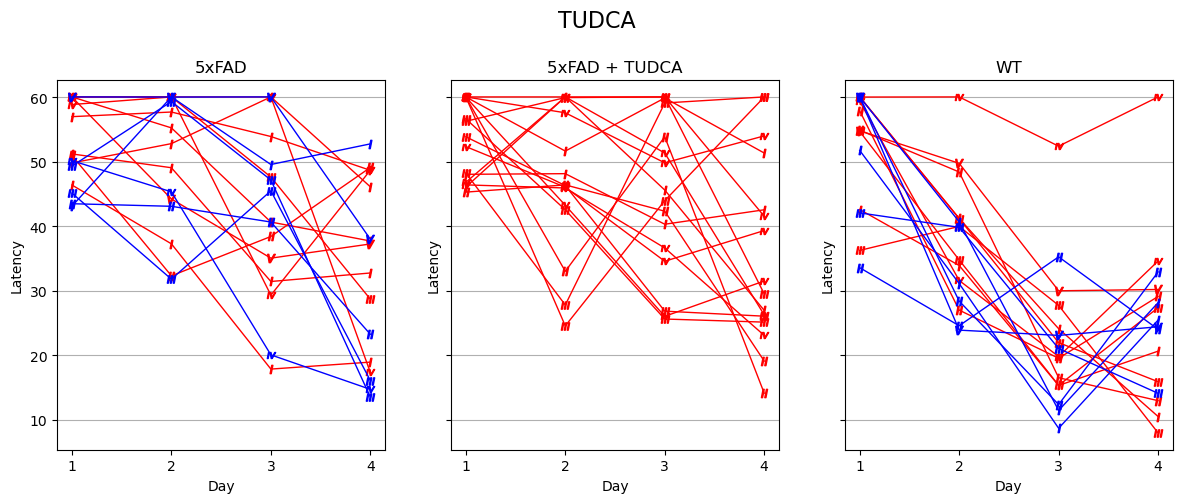

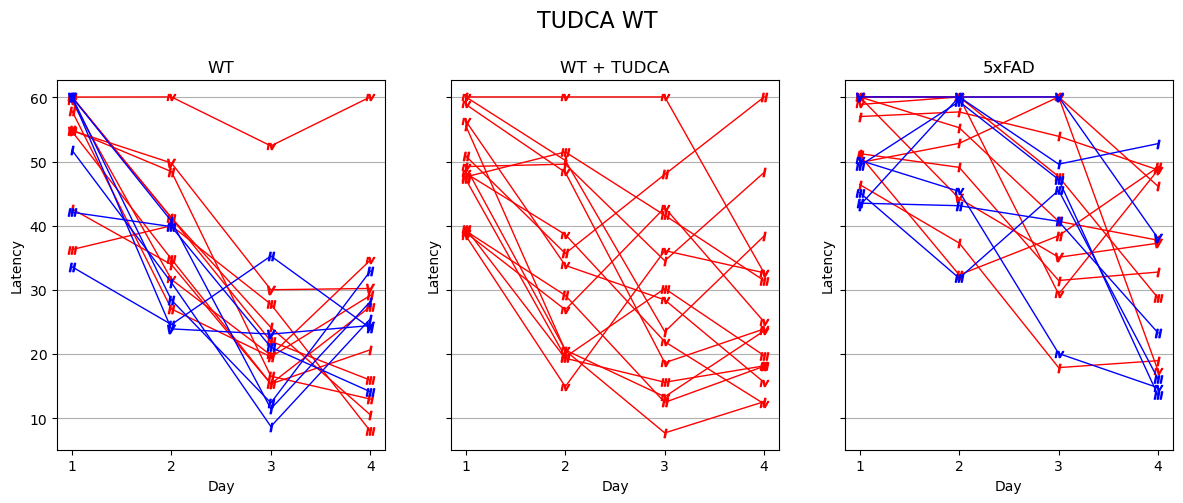

In [8]:
for k, v in experiments.items():
    fig, ax = latency_plotter(k, *v)
    attila_utils.savefig(fig, 'latency-' + k.replace(' ', '-'))

['named-figure/fraction-of-censored-latencies-CO26990.png',
 'named-figure/fraction-of-censored-latencies-CO26990.pdf']

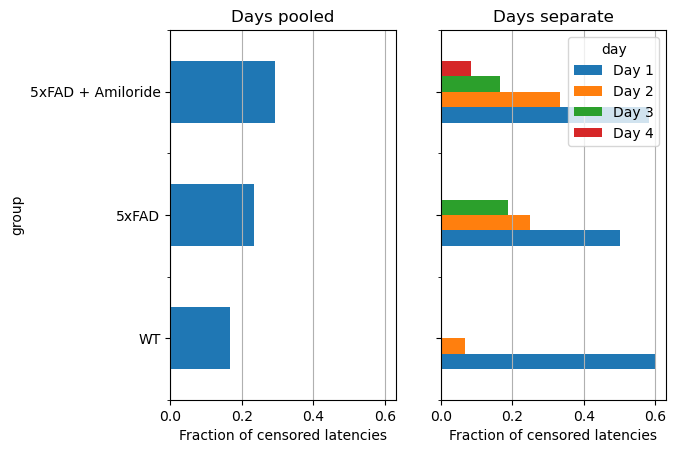

In [9]:
def plot_censored_fraction(data_train, group2condition):
    fig, ax = plt.subplots(1, 2, sharex=True, sharey=True)
    for title, axi, by in zip(['Days pooled', 'Days separate'], ax, ['group', ['group', 'day']]):
        s = (data_train['Latency'] >= 60).groupby(by).mean()
        d = s.unstack() if axi == ax[1] else s
        d.plot(kind='barh', ax=axi)
        #(data_train['Latency (s)'] >= 60).groupby(by).mean().unstack().plot(kind='barh', ax=axi)
        axi.set_yticklabels(group2condition.values())
        axi.set_xlabel('Fraction of censored latencies')
        axi.grid(axis='x')
        axi.set_title(title)
    return((fig, ax))

fig, ax = plot_censored_fraction(data_train1, group2condition1)
attila_utils.savefig(fig, 'fraction-of-censored-latencies-CO26990')

['named-figure/fraction-of-censored-latencies-CO28152.png',
 'named-figure/fraction-of-censored-latencies-CO28152.pdf']

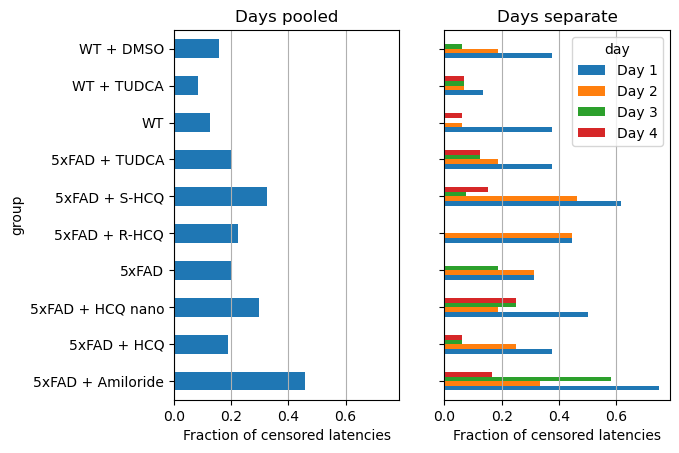

In [10]:
fig, ax = plot_censored_fraction(data_train2, group2condition2)
attila_utils.savefig(fig, 'fraction-of-censored-latencies-CO28152')

## Modeling: Testing bambi

See `def test_censored_response()` [here](https://github.com/bambinos/bambi/blob/169564fe640818525049d7d946636266e4a7b968/tests/test_built_models.py#L1002-L1049)

The `bambi.load_data` function fails for reasons explained in [this page](https://stackoverflow.com/questions/71603314/ssl-error-unsafe-legacy-renegotiation-disabled).  To circumvent that, download datasets with browser onto a local disk and then use `pandas.read_csv` (see urls [here](https://app.codecov.io/gh/bambinos/bambi/pull/697/blob/bambi/data/datasets.py)):

In [11]:
fpath = '../../resources/testdata/bambi/kidney.csv'
kidney = pd.read_csv(fpath)
kidney['status'] = kidney.censored.apply(lambda x: 'none' if x else 'right')
kidney

time  censored  patient  recur  age     sex disease status
0      8         0        1      1   28    male   other  right
1     23         0        2      1   48  female      GN  right
2     22         0        3      1   32    male   other  right
3    447         0        4      1   31  female   other  right
4     30         0        5      1   10    male   other  right
..   ...       ...      ...    ...  ...     ...     ...    ...
71    24         1       22      2   30  female   other   none
72    46         1       24      2   43  female      AN   none
73     5         1       34      2   45  female      GN   none
74    16         1       36      2   42  female   other   none
75     8         1       38      2   60    male     PKD   none

[76 rows x 8 columns]

In [12]:
model = bmb.Model(
    'censored(time, status) ~ 1 + sex + age',
    kidney, 
    family='gamma',
    link='log',
    center_predictors=False
)
idata_kidney = model.fit()#init='adapt_diag')

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [censored(time, status)_alpha, Intercept, sex, age]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 55 seconds.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.


In [13]:
model_wb = bmb.Model(
    'censored(time, status) ~ 1 + sex + age',
    kidney, 
    family='weibull',
    link='log',
    center_predictors=False
)
idata_kidney_wb = model_wb.fit()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [censored(time, status)_alpha, Intercept, sex, age]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 43 seconds.


This fails with `TypeError: Encountered error in ELPD computation of compare.`

array([[<Axes: title={'center': 'Intercept'}>,
        <Axes: title={'center': 'Intercept'}>],
       [<Axes: title={'center': 'sex'}>, <Axes: title={'center': 'sex'}>],
       [<Axes: title={'center': 'age'}>, <Axes: title={'center': 'age'}>],
       [<Axes: title={'center': 'censored(time, status)_alpha'}>,
        <Axes: title={'center': 'censored(time, status)_alpha'}>]],
      dtype=object)

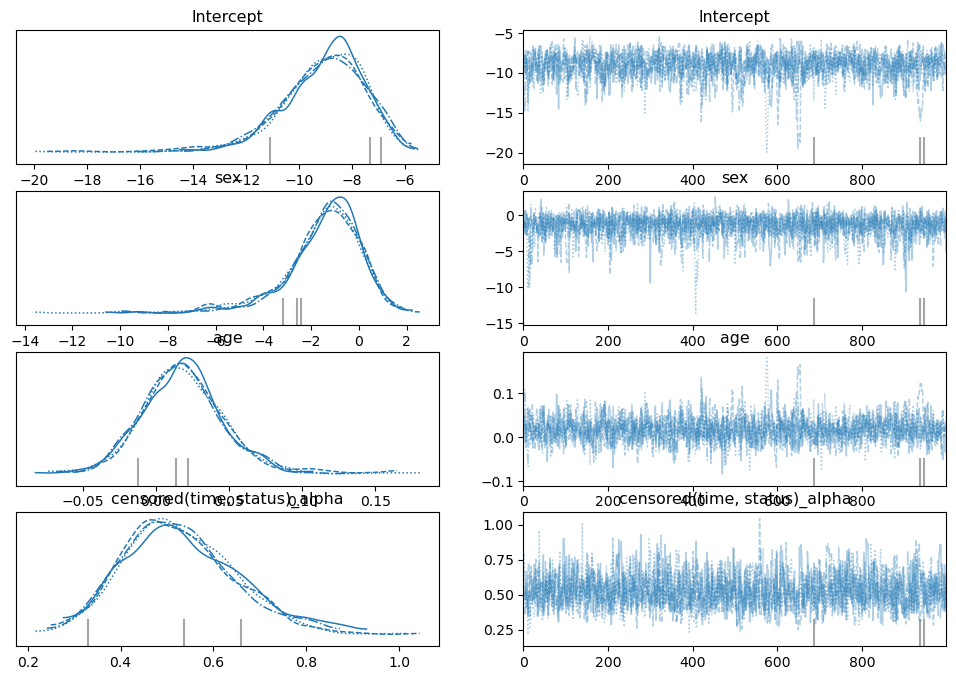

In [14]:
az.plot_trace(idata_kidney)

## Model selection for Fit MWM data

In [15]:
def create_models(data_train):

    models_train = {}

    models_train['M_2FE'] = bmb.Model(
        'censored(Latency, Status) ~ 1 + Day + Group',
        data_train, 
        family='weibull',
        link='log',
        center_predictors=False
    )

    models_train['M_4FE'] = bmb.Model(
        'censored(Latency, Status) ~ 1 + Day + Group + Sex + Velocity',
        data_train, 
        family='weibull',
        link='log',
        center_predictors=False
    )

    models_train['M_6FE'] = bmb.Model(
        'censored(Latency, Status) ~ 1 + Day + Group + Sex + Velocity + Thigmotaxis + Floating',
        data_train, 
        family='weibull',
        link='log',
        center_predictors=False
    )

    models_train['M_2FE_uncensored'] = bmb.Model(
        'Latency ~ 1 + Day + Group',
        data_train, 
        family='weibull',
        link='log',
        center_predictors=False
    )

    models_train['M_2FE_gamma'] = bmb.Model(
        'censored(Latency, Status) ~ 1 + Day + Group',
        data_train, 
        family='gamma',
        link='log',
        center_predictors=False
    )

    models_train['M_2FE_Rintcp|IRN'] = bmb.Model(
        'censored(Latency, Status) ~ 1 + Group + Day + (1 | IRN)',
        data_train, 
        family='weibull',
        link='log',
        center_predictors=False
    )

    models_train['M_2FE_Rday|IRN'] = bmb.Model(
        'censored(Latency, Status) ~ 1 + Group + Day + (0 + Day | IRN)',
        data_train, 
        family='weibull',
        link='log',
        center_predictors=False
    )

    models_train['M_2FE_Rintcp+Rday|IRN'] = bmb.Model(
        'censored(Latency, Status) ~ 1 + Group + Day + (1 + Day | IRN)',
        data_train, 
        family='weibull',
        link='log',
        center_predictors=False
    )

    models_train['M_2FE_Rintcp+Rday|Cohort/IRN'] = bmb.Model(
        'censored(Latency, Status) ~ 1 + Group + Day + (1 + Day | Cohort/IRN)',
        data_train, 
        family='weibull',
        link='log',
        center_predictors=False
    )


    models_train['M_4FE_Rday|IRN'] = bmb.Model(
        'censored(Latency, Status) ~ 1 + Day + Group + Sex + Velocity + (0 + Day | IRN)',
        data_train, 
        family='weibull',
        link='log',
        center_predictors=False
    )

    models_train['M_4FE_Rday|IRN_gamma'] = bmb.Model(
        'censored(Latency, Status) ~ 1 + Day + Group + Sex + Velocity + (0 + Day | IRN)',
        data_train, 
        family='gamma',
        link='log',
        center_predictors=False
    )

    models_train['M_4FE_Rintcp+Rday|Cohort/IRN'] = bmb.Model(
        'censored(Latency, Status) ~ 1 + Day + Group + Sex + Velocity + (1 + Day | Cohort/IRN)',
        data_train, 
        family='weibull',
        link='log',
        center_predictors=False
    )

    for m in models_train.values():
        m.build()
    
    return(models_train)

models_train1 = create_models(data_train1)

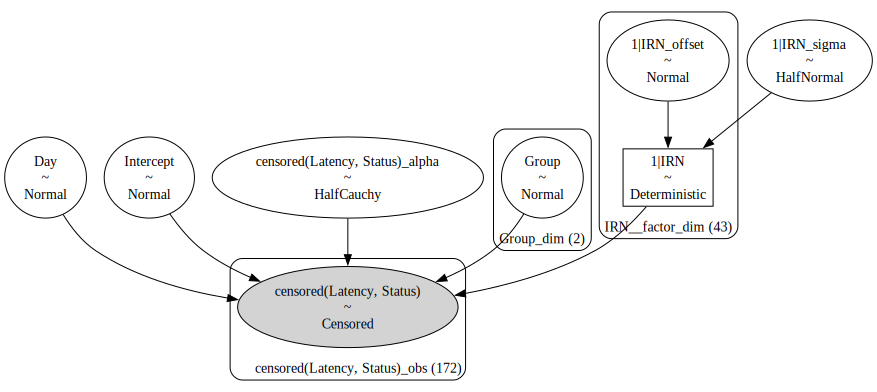

In [16]:
gv = models_train1['M_2FE_Rintcp|IRN'].graph()
gv.save(filename='M_2FE_Rintcp_IRN', directory='named-figure/')
gv

In [17]:
def my_fit(model):
    try:
        mcmc_random_seed = [1947, 1949, 1976, 2021]
        val = model.fit(idata_kwargs={'log_likelihood': True}, random_seed=mcmc_random_seed)
    except(pm.SamplingError):
        val = None
    return(val)

idata_train1 = {k: my_fit(v) for k, v in models_train1.items()}

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [censored(Latency, Status)_alpha, Intercept, Day, Group]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 41 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [censored(Latency, Status)_alpha, Intercept, Day, Group, Sex, Velocity]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 58 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [censored(Latency, Status)_alpha, Intercept, Day, Group, Sex, Velocity, Thigmotaxis, Floating]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 77 seconds.
There were 1 divergences after tuning. Increase `target_accept` or reparameterize.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Latency_alpha, Intercept, Day, Group]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 42 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [censored(Latency, Status)_alpha, Intercept, Group, Day, Day|IRN_sigma, Day|IRN_offset]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 51 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [censored(Latency, Status)_alpha, Intercept, Group, Day, 1|IRN_sigma, 1|IRN_offset, Day|IRN_sigma, Day|IRN_offset]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 62 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 1006 divergences after tuning. Increase `target_accept` or reparameterize.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [censored(Latency, Status)_alpha, Intercept, Day, Group, Sex, Velocity, Day|IRN_sigma, Day|IRN_offset]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 55 seconds.
There were 39 divergences after tuning. Increase `target_accept` or reparameterize.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


In [18]:
idata_train1

{'M_2FE': Inference data with groups:
 	> posterior
 	> log_likelihood
 	> sample_stats
 	> observed_data,
 'M_4FE': Inference data with groups:
 	> posterior
 	> log_likelihood
 	> sample_stats
 	> observed_data,
 'M_6FE': Inference data with groups:
 	> posterior
 	> log_likelihood
 	> sample_stats
 	> observed_data,
 'M_2FE_uncensored': Inference data with groups:
 	> posterior
 	> log_likelihood
 	> sample_stats
 	> observed_data,
 'M_2FE_gamma': None,
 'M_2FE_Rintcp|IRN': None,
 'M_2FE_Rday|IRN': Inference data with groups:
 	> posterior
 	> log_likelihood
 	> sample_stats
 	> observed_data,
 'M_2FE_Rintcp+Rday|IRN': Inference data with groups:
 	> posterior
 	> log_likelihood
 	> sample_stats
 	> observed_data,
 'M_2FE_Rintcp+Rday|Cohort/IRN': None,
 'M_4FE_Rday|IRN': Inference data with groups:
 	> posterior
 	> log_likelihood
 	> sample_stats
 	> observed_data,
 'M_4FE_Rday|IRN_gamma': None,
 'M_4FE_Rintcp+Rday|Cohort/IRN': None}

Repeat MCMC sampling for a few cases where `pymc.SamplingError` or other issue (judged from ELPD LOO) occurred.

In [19]:
k = 'M_2FE_gamma'
idata_train1[k] = models_train1[k].fit(idata_kwargs={'log_likelihood': True}, random_seed=[11947, 11949, 11976, 12021])

k = 'M_2FE_Rintcp|IRN'
idata_train1[k] = models_train1[k].fit(idata_kwargs={'log_likelihood': True}, random_seed=[11947, 11949, 11976, 12021])

k = 'M_2FE_Rintcp+Rday|IRN'
idata_train1[k] = models_train1[k].fit(idata_kwargs={'log_likelihood': True}, random_seed=[11947, 11949, 11976, 12021])

k = 'M_2FE_Rintcp+Rday|Cohort/IRN'
idata_train1[k] = models_train1[k].fit(idata_kwargs={'log_likelihood': True}, random_seed=[111947, 111949, 111976, 112021])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [censored(Latency, Status)_alpha, Intercept, Day, Group]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 57 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [censored(Latency, Status)_alpha, Intercept, Group, Day, 1|IRN_sigma, 1|IRN_offset]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 40 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [censored(Latency, Status)_alpha, Intercept, Group, Day, 1|IRN_sigma, 1|IRN_offset, Day|IRN_sigma, Day|IRN_offset]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 48 seconds.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [censored(Latency, Status)_alpha, Intercept, Group, Day, 1|Cohort_sigma, 1|Cohort_offset, 1|Cohort:IRN_sigma, 1|Cohort:IRN_offset, Day|Cohort_sigma, Day|Cohort_offset, Day|Cohort:IRN_sigma, Day|Cohort:IRN_offset]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 102 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 234 divergences after tuning. Increase `target_accept` or reparameterize.


The following fits gave `pymc.SamplingError` after trying out 5-6 different random seed settings.

In [20]:
compare_train1 = az.compare({k: v for k, v in idata_train1.items() if v is not None})
#compare_train = az.compare(idata_train)
#compare_train = compare_train.drop('M_2FE_Rintcp+Rday|IRN')
compare_train1

/Users/jonesa7/opt/anaconda3/envs/bayes/lib/python3.11/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/Users/jonesa7/opt/anaconda3/envs/bayes/lib/python3.11/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/Users/jonesa7/opt/anaconda3/e

rank    elpd_loo      p_loo   elpd_diff  \
M_6FE                            0 -541.772443   9.432977    0.000000   
M_2FE_Rintcp+Rday|Cohort/IRN     1 -573.823172  33.481225   32.050728   
M_2FE_Rintcp+Rday|IRN            2 -574.139853  30.726262   32.367409   
M_2FE_Rintcp|IRN                 3 -575.520853  27.029740   33.748410   
M_2FE_Rday|IRN                   4 -575.833671  26.487888   34.061227   
M_4FE_Rday|IRN                   5 -577.134379  27.961488   35.361935   
M_2FE_gamma                      6 -583.758891   4.549594   41.986447   
M_4FE                            7 -585.550577   7.842082   43.778134   
M_2FE                            8 -586.461771   5.268422   44.689328   
M_2FE_uncensored                 9 -697.557280   4.426625  155.784836   

                                    weight         se        dse  warning  \
M_6FE                         9.241727e-01  19.808180   0.000000    False   
M_2FE_Rintcp+Rday|Cohort/IRN  7.582734e-02  19.009999   8.683193     True   
M_2FE_Rintcp+Rday|IRN         3.314384e-12  18.791035   8.617242     True   
M_2FE_Rintcp|IRN              2.373949e-12  18.912832   8.641468     True   
M_2FE_Rday|IRN                2.127989e-12  18.403632   8.457532     True   
M_4FE_Rday|IRN                2.176199e-12  18.775067   8.678601     True   
M_2FE_gamma                   1.407454e-12  18.189605   8.534237    False   
M_4FE                         1.797747e-12  18.595895   8.904507    False   
M_2FE                         1.663354e-12  18.072295   8.784434    False   
M_2FE_uncensored              0.000000e+00   6.951455  21.724951    False   

                             scale  
M_6FE                          log  
M_2FE_Rintcp+Rday|Cohort/IRN   log  
M_2FE_Rintcp+Rday|IRN          log  
M_2FE_Rintcp|IRN               log  
M_2FE_Rday|IRN                 log  
M_4FE_Rday|IRN                 log  
M_2FE_gamma                    log  
M_4FE                          log  
M_2FE                          log  
M_2FE_uncensored               log

['named-figure/model-comparison-all.png',
 'named-figure/model-comparison-all.pdf']

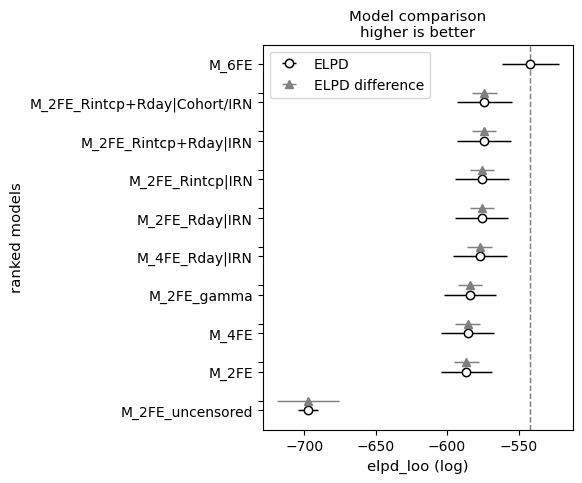

In [21]:
fig, ax = plt.subplots(figsize=(4, compare_train1.shape[0] * 0.5))
az.plot_compare(compare_train1, ax=ax, textsize=10)
ax.legend()
attila_utils.savefig(fig, 'model-comparison-all')

### Random effects

/Users/jonesa7/opt/anaconda3/envs/bayes/lib/python3.11/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/Users/jonesa7/opt/anaconda3/envs/bayes/lib/python3.11/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/Users/jonesa7/opt/anaconda3/e

['named-figure/model-comparison-randomfx.png',
 'named-figure/model-comparison-randomfx.pdf']

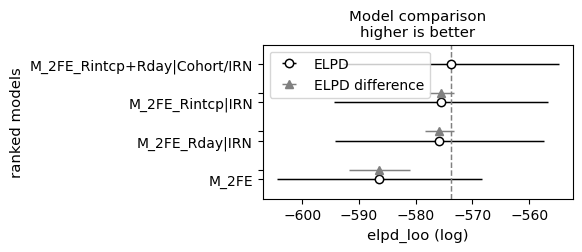

In [22]:
def compare_sel_mod(sel_mod, idata_train=idata_train1, return_df=False):
    cmp = az.compare({k: v for k, v in idata_train.items() if k in sel_mod})
    if return_df:
        return(cmp)
    fig, ax = plt.subplots(figsize=(4, cmp.shape[0] * 0.5))
    g = az.plot_compare(cmp, ax=ax, textsize=10)
    ax.legend()
    return((fig, ax))

sel_mod = ['M_2FE', 'M_2FE_Rintcp|IRN', 'M_2FE_Rday|IRN', 'M_2FE_Rintcp+Rday|Cohort/IRN']
fig, ax = compare_sel_mod(sel_mod)
attila_utils.savefig(fig, 'model-comparison-randomfx')

### Error distribution: gamma vs Weibull

The gamma distribution yields better fit based on ELPD but the improvement (see `elpd_diff`) is only slightly greater than the dSE (see `dse`).  Therefore, given the difficulty to fit the gamma model, I will favor the Weibull model.

['named-figure/model-comparison-errordist.png',
 'named-figure/model-comparison-errordist.pdf']

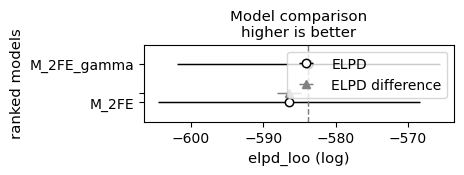

In [23]:
sel_mod = ['M_2FE', 'M_2FE_gamma']
fig, ax = compare_sel_mod(sel_mod, idata_train=idata_train1)
attila_utils.savefig(fig, 'model-comparison-errordist')

### Additional covariates

['named-figure/model-comparison-covariates.png',
 'named-figure/model-comparison-covariates.pdf']

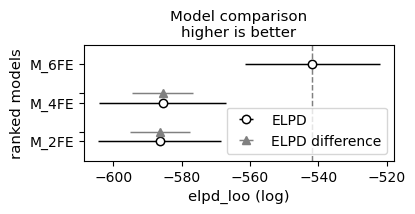

In [24]:
sel_mod = ['M_2FE', 'M_4FE', 'M_6FE']
fig, ax = compare_sel_mod(sel_mod, idata_train=idata_train1)
attila_utils.savefig(fig, 'model-comparison-covariates')

## Fit diagnostics

['named-figure/mcmc-trace-M_2FE_Rday_IRN.png',
 'named-figure/mcmc-trace-M_2FE_Rday_IRN.pdf']

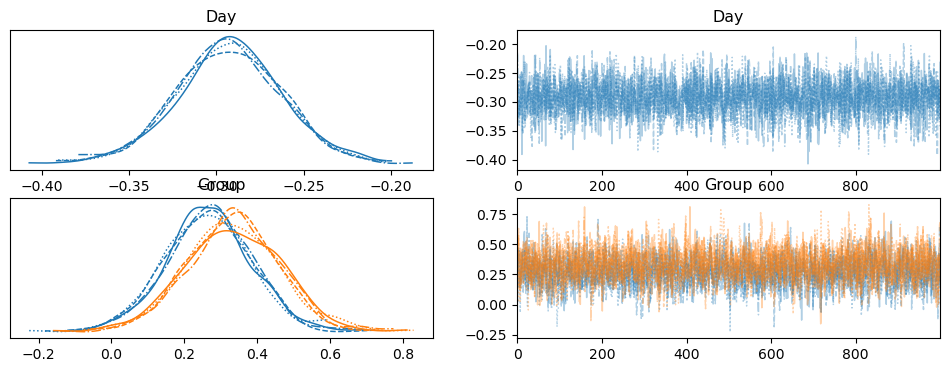

In [25]:
ax = az.plot_trace(idata_train1['M_2FE_Rintcp|IRN'], var_names=['Day', 'Group'])
fig = ax[0, 0].figure
attila_utils.savefig(fig, 'mcmc-trace-M_2FE_Rday_IRN')

In [26]:
def get_diagnostics(fun=az.ess, idata_train={k:v for k, v in idata_train1.items() if k != 'M_2FE_Rintcp+Rday|IRN'}):
    s = pd.Series(idata_train).dropna()
    l = [s.apply(lambda x: fun(x, var_names=v).to_dict()['data_vars'][v]['data']).to_frame(v) for v in ['Intercept', 'Day']]
    l += [s.apply(lambda x: fun(x, var_names='Group').to_dict()['data_vars']['Group']['data'][i]).to_frame(n) for i, n in zip(range(2), ['Group B', 'Group C'])]
    df = pd.concat(l, axis=1)
    precision = np.int64(3 - np.round(np.log10(df.mean().mean())))
    val = df.style.format(precision=precision).background_gradient(axis=None, vmin=df.min().min(), vmax=df.max().max(), cmap='hot')
    return(val)

get_diagnostics(az.ess)

In [27]:
get_diagnostics(az.rhat)

In [28]:
get_diagnostics(az.mcse)

['named-figure/model-comparison-94pct_CI.png',
 'named-figure/model-comparison-94pct_CI.pdf']

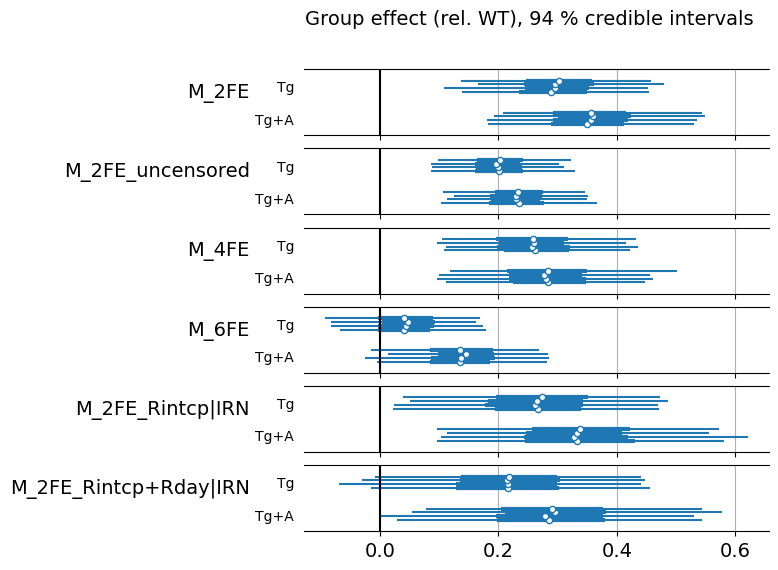

In [29]:
sel_models = ['M_2FE', 'M_2FE_uncensored', 'M_4FE', 'M_6FE', 'M_2FE_Rintcp|IRN', 'M_2FE_Rintcp+Rday|IRN']
fig, ax = plt.subplots(len(sel_models), 1, sharex=True, figsize=(6, 1 * len(sel_models)))
for m, axi in zip(sel_models, ax):
    az.plot_forest(idata_train1[m], var_names=['Group'], ax=axi, ess=False)
    #axi.set_title(m, backgroundcolor= 'white')
    axi.set_title('')
    axi.set_ylabel(m, rotation='horizontal', horizontalalignment='right', fontsize=14)
    axi.set_yticklabels(['Tg+A', 'Tg'], fontsize=10)
    #axi.set_xticklabels(axi.get_xticklabels())
    axi.grid(axis='x')
    axi.axvline(0, color='black')

fig.suptitle('Group effect (rel. WT), 94 % credible intervals', fontsize=14)
    
attila_utils.savefig(fig, 'model-comparison-94pct_CI')

## Modeling directly with PyMC

The Weibull distribution has two parameters: $\alpha$ (shape) and $\beta$ (scale); see this [PyMC doc](https://www.pymc.io/projects/docs/en/latest/api/distributions/generated/pymc.Weibull.html#pymc.Weibull).  It's mean $\mu$ is:
\begin{equation}
\mu = \beta \Gamma \left( 1 + \frac{1}{\alpha} \right) \; 
\Rightarrow \;
\beta = \frac{\mu}{\Gamma \left( 1 + \frac{1}{\alpha} \right)}
\end{equation}

In [30]:
mwm.get_Weibull_beta(10)

True_div.0

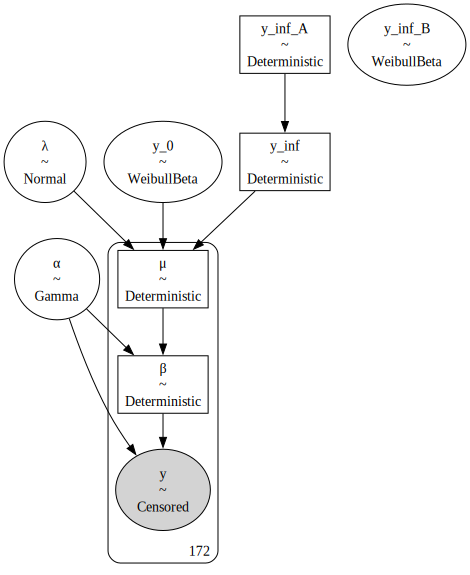

In [31]:
y_obs = data_train1.Latency.values
x_obs = data_train1.Day.values
gv = pm.model_to_graphviz(mwm.model_A(y_obs, x_obs, return_model=True, y_inf_A_val=0, censored=True))
gv

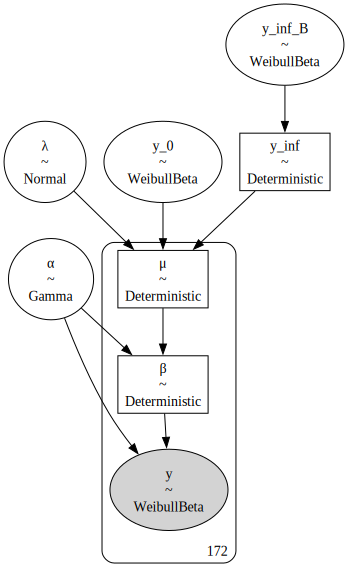

In [32]:
gv = pm.model_to_graphviz(mwm.model_A(y_obs, x_obs, return_model=True, y_inf_A_val=None, censored=False))
gv

In [33]:
d = {'y_inf random': None, 'y_inf = 0': 0, 'y_inf = 10': 10}
#d = {'y_inf random': [None, True], 'y_inf = 0': [0, True], 'y_inf = 10': [10, True], 'y_inf = 10': [10, True]}
idata_1 = {k: mwm.model_A(y_obs, x_obs, return_model=False, y_inf_A_val=v, censored=False) for k, v in d.items()}

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag_grad...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [y_0, y_inf_B, λ, α]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 33 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 111 divergences after tuning. Increase `target_accept` or reparameterize.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag_grad...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [y_0, y_inf_B, λ, α]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 32 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag_grad...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [y_0, y_inf_B, λ, α]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 30 seconds.


In [34]:
az.compare(idata_1)

rank    elpd_loo     p_loo  elpd_diff    weight        se  \
y_inf random     0 -703.133638  2.547686   0.000000  0.637832  6.883183   
y_inf = 0        1 -703.144920  2.594337   0.011282  0.362168  6.895963   
y_inf = 10       2 -703.165876  2.591466   0.032238  0.000000  6.887549   

                   dse  warning scale  
y_inf random  0.000000    False   log  
y_inf = 0     0.285479    False   log  
y_inf = 10    0.119409    False   log

array([[<Axes: title={'center': 'λ'}>, <Axes: title={'center': 'λ'}>],
       [<Axes: title={'center': 'y_0'}>, <Axes: title={'center': 'y_0'}>],
       [<Axes: title={'center': 'y_inf_B'}>,
        <Axes: title={'center': 'y_inf_B'}>],
       [<Axes: title={'center': 'α'}>, <Axes: title={'center': 'α'}>],
       [<Axes: title={'center': 'y_inf'}>,
        <Axes: title={'center': 'y_inf'}>],
       [<Axes: title={'center': 'μ'}>, <Axes: title={'center': 'μ'}>],
       [<Axes: title={'center': 'β'}>, <Axes: title={'center': 'β'}>]],
      dtype=object)

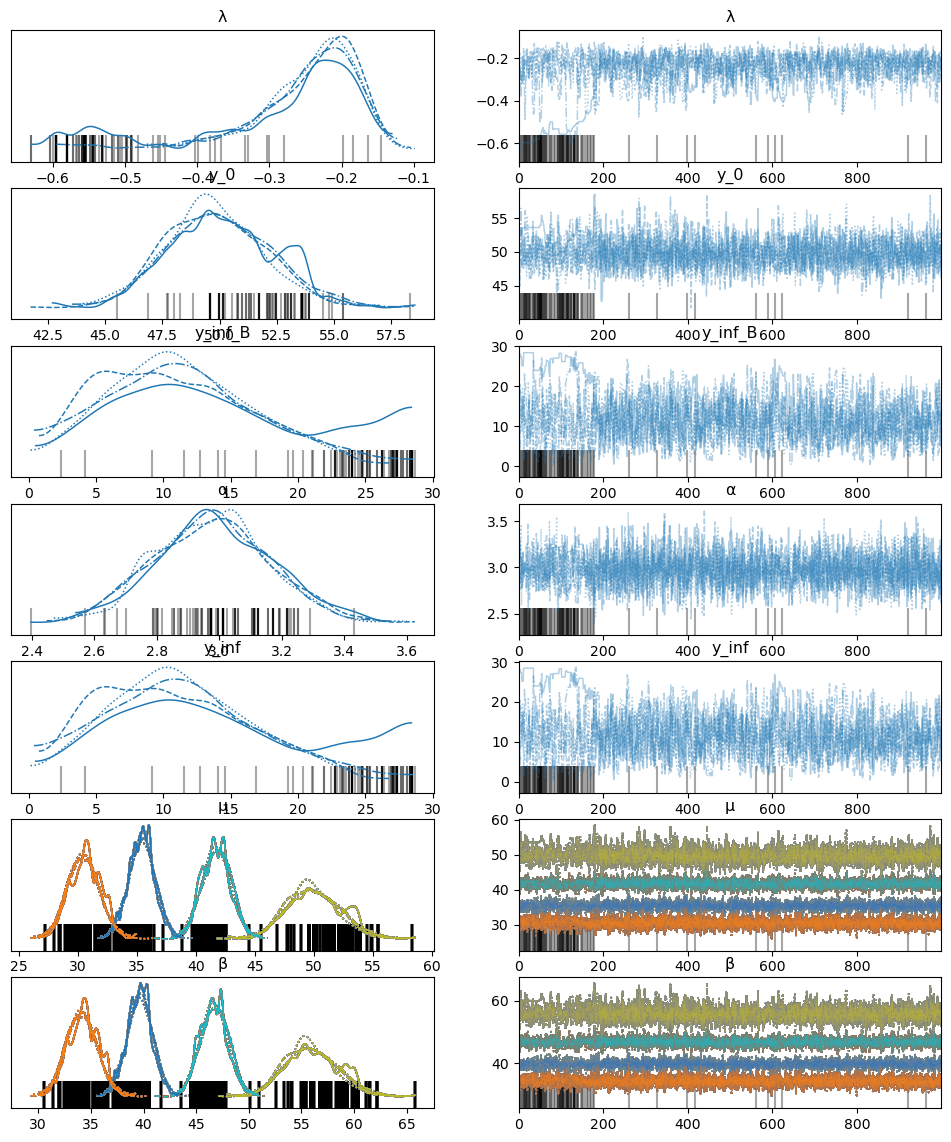

In [35]:
az.plot_trace(idata_1['y_inf random'])

array([[<Axes: title={'center': 'λ'}>, <Axes: title={'center': 'λ'}>],
       [<Axes: title={'center': 'y_0'}>, <Axes: title={'center': 'y_0'}>],
       [<Axes: title={'center': 'y_inf_B'}>,
        <Axes: title={'center': 'y_inf_B'}>],
       [<Axes: title={'center': 'α'}>, <Axes: title={'center': 'α'}>],
       [<Axes: title={'center': 'y_inf_A'}>,
        <Axes: title={'center': 'y_inf_A'}>],
       [<Axes: title={'center': 'y_inf'}>,
        <Axes: title={'center': 'y_inf'}>],
       [<Axes: title={'center': 'μ'}>, <Axes: title={'center': 'μ'}>],
       [<Axes: title={'center': 'β'}>, <Axes: title={'center': 'β'}>]],
      dtype=object)

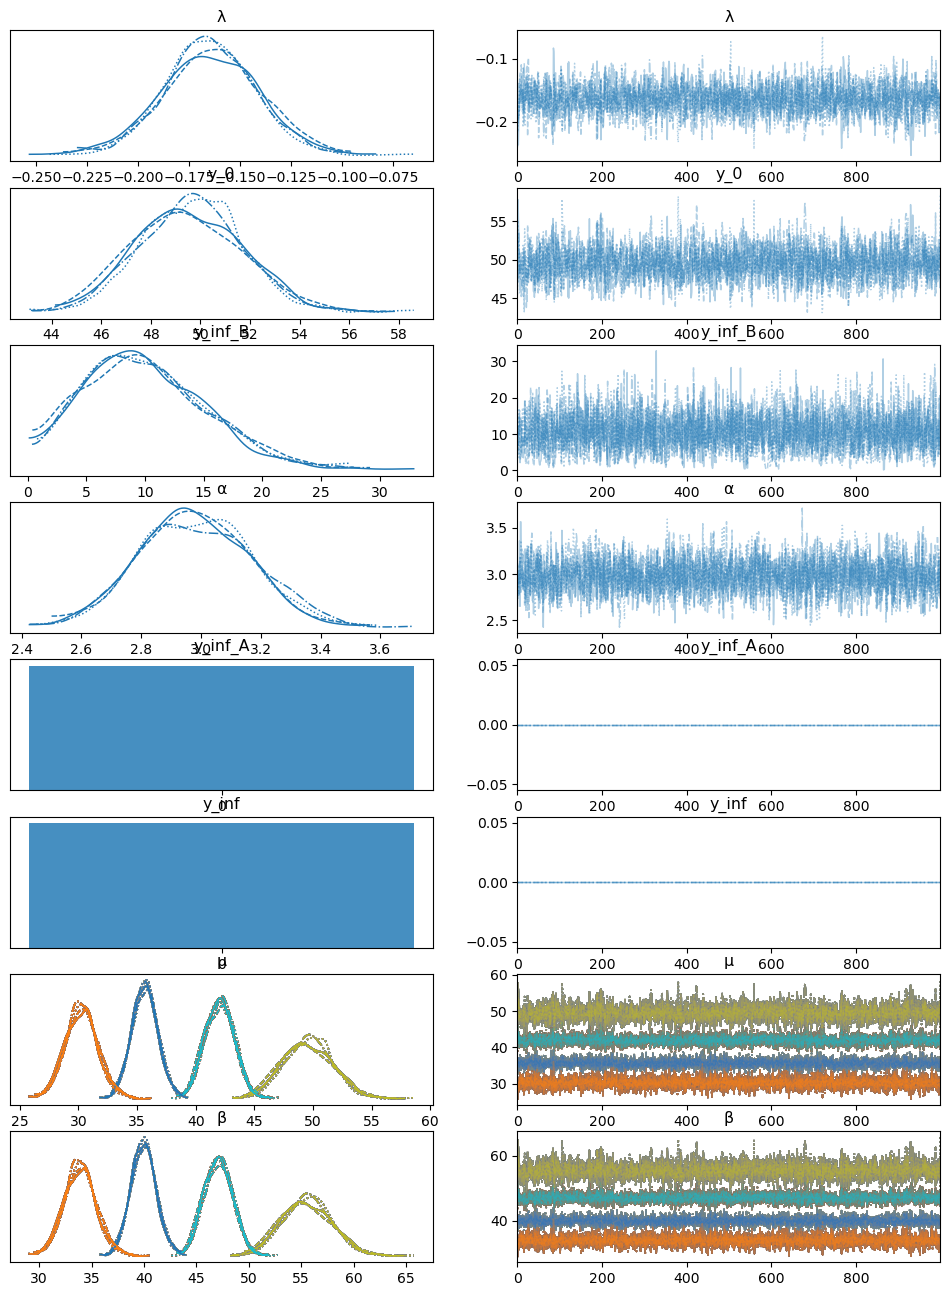

In [36]:
az.plot_trace(idata_1['y_inf = 0'])

In [37]:
%connect_info

{
  "shell_port": 53280,
  "iopub_port": 53281,
  "stdin_port": 53282,
  "control_port": 53284,
  "hb_port": 53283,
  "ip": "127.0.0.1",
  "key": "271dd82c-b73f65f5a16c1b58f914d6e2",
  "transport": "tcp",
  "signature_scheme": "hmac-sha256",
  "kernel_name": "python3"
}

Paste the above JSON into a file, and connect with:
    $> jupyter <app> --existing <file>
or, if you are local, you can connect with just:
    $> jupyter <app> --existing kernel-d730793a-4339-469c-a954-2b07d9d34217.json
or even just:
    $> jupyter <app> --existing
if this is the most recent Jupyter kernel you have started.
